# INF200 Lecture No. Ja04

### Hans Ekkehard Plesser
### 7 January 2021

## Today's topics

- Expected model dynamics (single location)
- Random selection
- Creating documentation with Sphinx

## Expected model dynamics

To provide you with a reference for expected model dynamics, I have run 

- 10 different simulations with only herbivores in a single Lowland location
- 50 different simulations with herbivores and carnivores in a single Lowland location

All simulations use default parameters.

- All animals have identical initial parameters.
- Carnivores are added after 50 years

### Simulation script (herbivores and carnivores)

This script uses an additional feature in `BioSim` (not required in the project description) allowing the usr to specify a `log_file`. For each year, the number of herbivores and carnivores on the island is written to the file.

The loop in the script is over different simulations, with a different random generator seed for each simulation. Output file names include the seed value.

```python
import textwrap
from biosim.simulation import BioSim

geogr = """WWW
           WLW
           WWW"""
geogr = textwrap.dedent(geogr)

ini_herbs = [{'loc': (2, 2),
              'pop': [{'species': 'Herbivore', 'age': 5, 'weight': 20}
                      for _ in range(50)]}]
ini_carns = [{'loc': (2, 2),
              'pop': [{'species': 'Carnivore', 'age': 5, 'weight': 20}, 
                      for _ in range(20)]}]

for seed in range(100, 150):
    sim = BioSim(geogr, ini_herbs, seed=seed,
                 img_base='../data/mono_hc_{:05d}'.format(seed),
                 log_file='../data/mono_hc_{:05d}.csv'.format(seed))
    sim.simulate(50, img_years=300)
    sim.add_population(ini_carns)
    sim.simulate(250, img_years=300)
```

### Sample log file

```
# Year, Herbivore Count, Carnivore Count
0, 50, 0
1, 48, 0
2, 90, 0
...
297, 70, 42
298, 77, 42
299, 82, 42
```

### Analysing data

#### Herbivore only

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
data = []
for s in range(100, 110):
    d = pd.read_csv(f'../../../inf200-internal/biosim_project/data/mono_ho_{s:05d}.csv', 
                    names=['Year', 'Herbivores', 'Carnivores'],
                    skiprows=1, index_col=0).drop('Carnivores', axis=1)
    d['Seed'] = s
    data.append(d)
hd = pd.concat(data).pivot(columns='Seed')
hd.head()

Herbivores                                           
Seed        100  101  102  103  104  105 106 107  108  109
Year                                                      
0            50   50   50   50   50   50  50  50   50   50
1            48   44   49   49   46   47  46  47   46   45
2            86   78   84   85   82   82  83  74   81   77
3           100   92  106  107   99  102  96  89  105   96
4           106  102  106  118  105  108  98  99  105  106

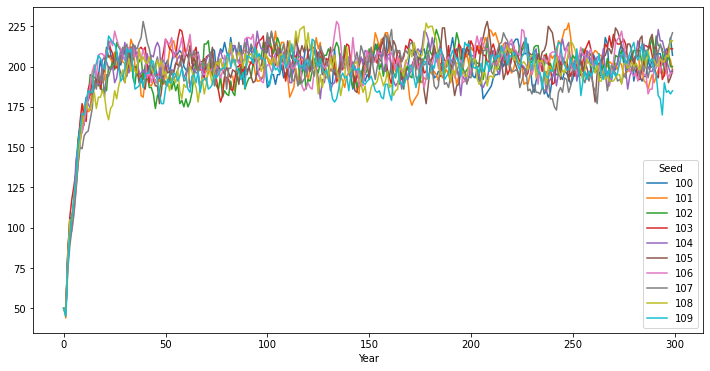

In [3]:
hd.Herbivores.plot();

Compute some statistics for the late part of he simulation, after the initial transition. We set the limit somewhat arbitrarily at 100 years.

In [4]:
hd_eq = hd.loc[hd.index >= 100, :]

Look first at mean and standard deviation for each individual simulation.

In [5]:
hd_eq.mean()

            Seed
Herbivores  100     200.310
            101     201.730
            102     203.545
            103     204.785
            104     202.125
            105     205.275
            106     202.625
            107     199.410
            108     201.095
            109     198.760
dtype: float64

In [6]:
hd_eq.std()

            Seed
Herbivores  100     8.112519
            101     9.972681
            102     7.308560
            103     6.655845
            104     8.230924
            105     9.185381
            106     8.018470
            107     9.987022
            108     9.301536
            109     8.776533
dtype: float64

Values are consistent across simulations.

Now combine data from all simulations and compute overall mean and std.

In [7]:
hd_eq.unstack().mean()

201.966

In [8]:
hd_eq.unstack().std()

8.840696972608027

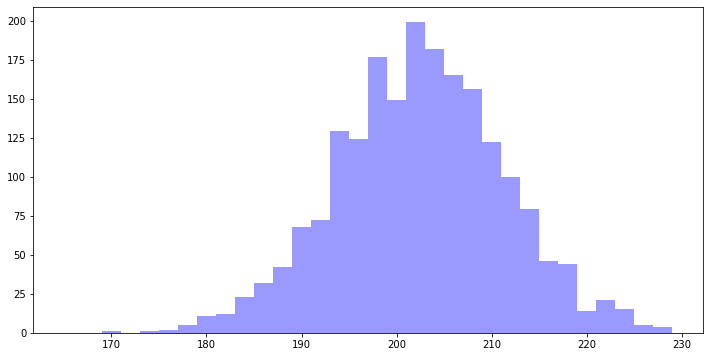

In [9]:
bins = np.arange(165, 230, 2)
plt.hist(hd_eq.Herbivores.unstack(), bins=bins, fc='b', histtype='stepfilled', alpha=0.4);

#### Summary for herbivores only

- 202.0 ± 8.8 herbivores
- Distribution looks reasonably normal, but with some surprising peaks
- When checking your simulation, if your animal count is around 200 in the long run, things are probably fine.

### Herbivores and Carnivores

In [10]:
data = []
for s in range(100, 150):
    d = pd.read_csv(f'../../../inf200-internal/biosim_project/data/mono_hc_{s:05d}.csv', 
                    names=['Year', 'Herbivores', 'Carnivores'],
                    skiprows=1, index_col=0)
    d['Seed'] = s
    data.append(d)
hc = pd.concat(data).pivot(columns='Seed')
hc.tail()

Herbivores                                       ... Carnivores          \
Seed        100 101 102 103  104 105 106 107 108 109  ...        140 141 142   
Year                                                  ...                      
295          89  89  92  48   93  86  87  89  80  80  ...          0  48  40   
296          97  75  93  58   91  92  98  81  74  92  ...          0  48  40   
297          99  77  88  64  100  96  89  77  70  97  ...          0  50  38   
298         100  90  93  66  100  91  96  74  77  90  ...          0  53  41   
299         102  82  88  73  103  94  96  74  82  86  ...          0  52  46   

                                  
Seed 143 144 145 146 147 148 149  
Year                              
295   68  24  42  41  41   0   0  
296   65  24  42  49  43   0   0  
297   62  23  46  50  41   0   0  
298   61  27  39  44  38   0   0  
299   55  29  40  46  40   0   0  

[5 rows x 100 columns]

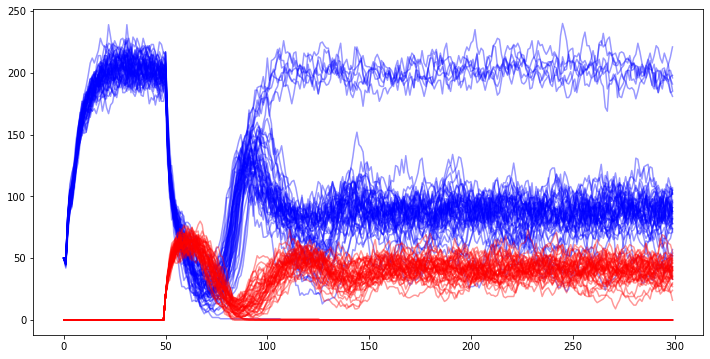

In [11]:
plt.plot(hc.Herbivores, 'b', alpha=0.4);
plt.plot(hc.Carnivores, 'r', alpha=0.4);

- We see two regimes: in some cases, carnivores die out befoe year 100, in others not
- Check in how many cases carnivores die out

In [12]:
sum(hc.loc[299, 'Carnivores'] == 0)

8

In [13]:
sum(hc.loc[299, 'Herbivores'] == 0)

1

Pick out those cases where Carnivores survive until the end, plot to check the picking worked right.

In [14]:
with_c = hc.loc[299, 'Carnivores'] > 0
hc_eq = hc.loc[hc.index >= 150, np.hstack((with_c.values, with_c.values))]

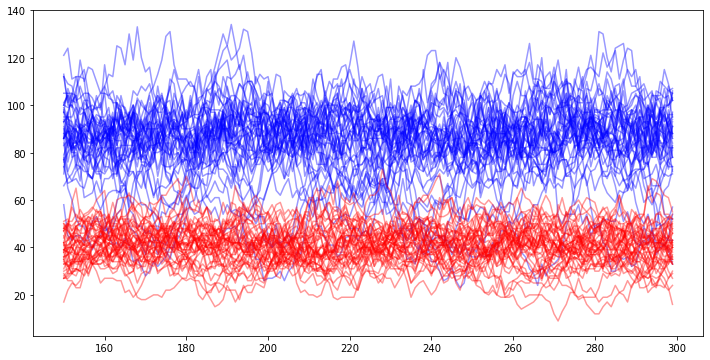

In [15]:
plt.plot(hc_eq.Herbivores, 'b', alpha=0.4);
plt.plot(hc_eq.Carnivores, 'r', alpha=0.4);

Look at averages

In [16]:
hc_eq.Herbivores.unstack().mean(), hc_eq.Herbivores.unstack().std()

(84.75698412698412, 15.552587829818705)

In [17]:
hc_eq.Carnivores.unstack().mean(), hc_eq.Carnivores.unstack().std()

(41.04333333333334, 8.288372684994298)

- 84.8 ± 15.6 herbivores
- 41.0 ± 8.3 carnivores

in those cases where both herbivores and carnivores survive.

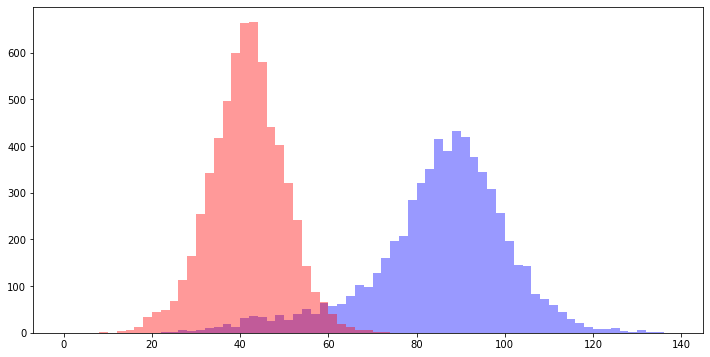

In [18]:
bins = np.arange(0, 140, 2)
plt.hist(hc_eq.Herbivores.unstack(), bins=bins, fc='b', histtype='stepfilled', alpha=0.4);
plt.hist(hc_eq.Carnivores.unstack(), bins=bins, fc='r', histtype='stepfilled', alpha=0.4);

## Random selection

### Case 1: Dead or alive

- An animal has a probability $p$ to die
- How do we decided if the animal will die in a given year?
    - Draw uniformly distributed random number from $[0, 1)$ and compare to $p$
    
### Case 2: Choosing between multiple alternaives

- Literature: Knuth, The Art of Computer Programming, vol 2, ch 3.3-3.4 
- In a simluation, we want to choose between four alternatives with probabilities $p_0, p_1, p_2, p_3$
- Note $\sum_{n=0}^3 p_n = 1$ by definition
- Cumulative probabilities $P_n = \sum_{k=0}^n p_k$ divide unit interval in sections corresponding to events 0, 1, 2, 3
- Specifically, we choose a random number $r$ and select 

\begin{equation}
\begin{cases}
\text{event}\: 0 \quad\text{if}\; r < P_0 \\
\text{event}\: n \quad\text{if}\; P_{n-1} \leq r < P_{n}\;\; \text{for}\; n>0
\end{cases}
\end{equation}

- The following code will select from `len(p)` alternatives with probabilities `p[0]`, `p[1]`, ...

In [19]:
def random_select(p):
    r = random.random()
    n = 0
    while r >= p[n]:
        r -= p[n]
        n += 1
    return n

### Simpler approach for our simulations

- Animals move in all four directions with *same* probability
- Can use `random.choice()` to pick one element from a list with equal probability

------------------

## Creating documentation with Sphinx

### What is Sphinx?

- [Sphinx](http://www.sphinx-doc.org/en/stable/) is a tool for generating documentation for your code
- Can compile documentation to many different formats: LaTeX, pdf, html, etc.
- Can read out docstrings in your code and include in the documentation

### Getting started: `sphinx-quickstart`

1. Open `Terminal` within PyCharm 
    - Alternative: open `Terminal` under OSX/Linux or `Anaconda Prompt` under Windows and navigate to your `biosim-gxx-Name1-Name2` folder (use `cd` to change directories)
1. Ensure your `inf200` conda environment is activated
1. Run the following command
```
sphinx-quickstart --ext-autodoc --ext-coverage --ext-mathjax --ext-viewcode docs
```
1. Accept default answers for questions by pressing ENTER and enter sensible values for
    - Project Name
    - Author Names(s)
    - Project version
1. Don't worry if you make a mistake, you can fix it in the `docs/conf.py` file
1. Open file `conf.py` in the `docs` directory and change the following lines (approx line 15) 

        #import os
        #import sys
        #sys.path.insert(0, os.path.abspath('.'))
        
    to
    
        import os
        import sys
        sys.path.insert(0, os.path.abspath('..'))
        autoclass_content = 'both'
        
     The first line ensures that Sphinx finds all code in the project directory, the second that documentation will be generated for all constructors.
1. Finally, add the following line at the end of `conf.py`

        latex_elements = {'papersize': 'a4paper'}

### Write documentation

1. Edit the `docs/index.rst` file and add additional documentation `*.rst` files
1. For a worked example, see `Project/SampleProjects/biolab_project`
1. For more information on restructured text, see
    - [Sphinx ReStructuredText primer](https://www.sphinx-doc.org/en/master/usage/restructuredtext/basics.html)
    - [Another ReStructuredText primer](https://docutils.sourceforge.io/docs/user/rst/quickstart.html)
    - [Full Sphinx ReStructuredText documentation](https://www.sphinx-doc.org/en/master/usage/restructuredtext/index.html)

### Generate documents

1. Open a Terminal (e.g. inside PyCharm) and navigate to the `docs`
folder inside your project.

1. Run 

        make html
        
    This will create basic documentation, which you by opening `docs/_build/html/index.html` 
    in a web browser.
    
1. If the command above does not work in the terminal you opened in PyCharm, try opening a normal Terminal, navigate to the `docs` directory and try again.
       
1. To create documentation in other formats, run, e.g.

        make epub
        make latexpdf

    The resulting documentation will be in the `epub` and `latex`
    directories, respectively. Creating these formats may require
    additional software on your computer, especially a working TeX
    system, e.g.

    - Windows: [MikTeX](http://miktex.org)
    - OSX: [MacTex](https://tug.org/mactex)

    Under Windows, you may have to run (replace `biolab` with `biosim`)
    
        ```
        make latex
        cd _build/latex
        pdflatex biolab
        ```
        
    If Sphinx tells you that Perl.exe is missing to build the LaTeX file, you can install Perl using `conda install perl` or install Perl from https://strawberryperl.com (not tested yet).

### Keep Sphinx-generated documentation out of Git repo!

The documentation that is generated in the `docs/_build` directory **should not be committed to your git repository**!

`docs/_build` should automatically be ignored by git if you have put the right `.gitignore` file in place (copied from course repo `project_description/sample.gitignore`.

If the `docs/_build` directory is not ignored by git, proceed as follows:
1. If you have not yet put `.gitignore` in place, do it now and see if `docs/_build` is ignored afterwards.
1. If the `docs/_build` build directory is still not ignored, there are a few possibilities:
    1. The `docs` directory has a different name, e.g. `Docs` or `doc`. Rename it to `docs`.
    1. The `docs` directory is not at the top level within the `BioSim_Gxx_Name1_Name2` folder. Move it to the top level.
    1. The `.gitignore` file is not at the top level within the `BioSim_Gxx_Name1_Name2` folder. Move it there.
    1. If none of this helps, contact Hans Ekkehard!
1. Commit your changes if you changed `.gitignore` or moved a directory.

### Formatting options for docstrings

Instead of the standard format for docstrings, e.g.,

```
def repeat(text, copies):
    """
    Repeat given text a given number of times.
    
    :param text: a string
    :param copies: an integer
    :return: string, text concatenated copies times
    """
```

one can also use NumPy-style docstrings which look like this

```
"""
Repeat given text a given number of times.

Parameters
----------
text : str
    Text to be repeated
copies : int
    Number of repetitions

Returns
-------
str
    Text concatenated copies times.
"""
```

For more on the NumPyDoc format, see
- http://numpydoc.readthedocs.io/en/latest/format.html
- http://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_numpy.html

To work with NumPyDoc docstrings, you need to do the following:
1. Install Sphinx Numpydoc extentsion
    - `conda install numpydoc`
    - `pip install numpydoc`
1. In `docs/conf.py`, around line 40, add `'sphinx.ext.napoleon'` to the list of `extensions`.
1. In PyCharm, open Preferences, go to `Tools > Python integrated tools` and select `Docstring format` NumPy

### Further  documentation on Sphinx

- [Sphinx homepage](http://sphinx-doc.org)
- ["Guided tour" to documenting with Sphinx](http://pythonhosted.org/an_example_pypi_project/sphinx.html)
- [Sphinx tutorial from the Matplotlib folks](http://matplotlib.org/sampledoc/)
- [A lot of projects using Sphinx for documentation](https://www.sphinx-doc.org/en/master/examples.html)
- [NEST Simulator documentation built with Sphinx](https://nest-simulator.readthedocs.io/en/nest-2.20.1/)